[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/baloghartur3/speaker-recognition/blob/main/Big_Homework.ipynb)

# Voice recognition

This notebook contains a deep learning solution for speaker recognition. It uses the VoxCeleb1 dataset, which contains the audio recordings of 1251 people.

### Reading the .csv file that contains the name for each ID

Each person has its own unique ID by which their sound files can be identified.
The ID - Name connection is stored in the .cvs file below.

The "vox1_meta.cvs" file needs to be in the working dir.

In [1]:
import pandas as pd

# The name of the columns, we need
col_list = ["VoxCeleb1 ID", "VGGFace1 ID"]

# Reading the file
df = pd.read_csv("vox1_meta.csv", usecols=col_list,sep='\t')

# We create a col with paths for each person's audio files
df['relative_path'] ='wav\\' + df['VoxCeleb1 ID'].astype(str) + '\\'

# Storing the names
df['name'] = df['VGGFace1 ID']
df = df[['relative_path', 'name']]
df

,relative_path,name
0,wav\id10001\,A.J._Buckley
1,wav\id10002\,A.R._Rahman
2,wav\id10003\,Aamir_Khan
3,wav\id10004\,Aaron_Tveit
4,wav\id10005\,Aaron_Yoo
...,...,...
1246,wav\id11247\,Zachary_Levi
1247,wav\id11248\,Zachary_Quinto
1248,wav\id11249\,Zack_Snyder
1249,wav\id11250\,Zoe_Saldana


### Functions for audio file operations

We need to create a function for opening the audio files and one for the audio augmentation.
For these, we use wavfile and numpy as well

In [2]:
from scipy.io import wavfile
import numpy as np

# ----------------------------
# Load an audio file. Return the signal as an array and the sample rate
# ----------------------------
def audio_open(audio_file):
    # Reading the signal to sig, and the sampling rate to sr
    sr, sig = wavfile.read(audio_file)
    return (sig, sr)

# ----------------------------
# Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds and get multiple audio slices from aud (num_samples)
# ----------------------------
def pad_trunc(aud, num_samples, max_ms):
    sig, sr = aud
    sig_len = sig.shape[0]
    max_len = sr//1000 * max_ms
    sigs = []
    
    # If the length is shorter than the expected, we concatenate the whole audio to itself
    if (sig_len < sr+max_len):
        sig = np.concatenate((sig, sig))
        sig_len = sig.shape[0]
       
    # Only in case of test and validation datasets
    if num_samples == 1:
        sigs = sig[sr:sr+max_len]
    # Augmentation
    else:
        # Calculate the step size
        contNum = int((sig_len-max_len)/(num_samples-1))
        for i in range(0, sig_len, contNum):
            if i == 0:
                sigs.append(sig[:max_len])
            elif len(sig[i:i+max_len])== sr*(max_ms/1000):
                sigs.append(sig[i:i+max_len])

    return (sigs, sr)

In [3]:
import os

# ----------------------------
# For a given path, it iterates through its directories and subdirectories, searching for audio files
# ----------------------------
def iterate(path, wav_paths, classes, class_id):
    count=0
    rootdir = path #df.iloc[0]['relative_path']
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            wav_paths.append(os.path.join(subdir, file))
            classes.append(class_id)
            count+=1
    return count

### Data prepocessing

Because of the imbalanced dataset we need to equalize the quantity of the audio files for each person. For this we duplicate
certain files.

We can set the number recognizable people with the num_of_classes variable.

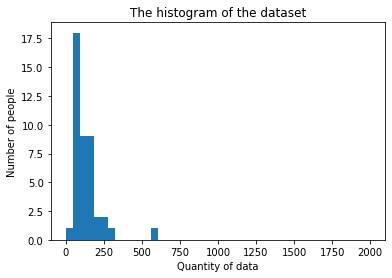

In [4]:
import matplotlib.pyplot as plt

# Storing th dataset (can be imbalanced)
wav_paths = []
classes = []
counts=[]

# To store the balanced dataset
new_class=[]
new_wav_path=[]

# Number of person we want to work with (up to ~1200)
num_of_classes=50

# Storing the paths for every audio files
for i in range(num_of_classes):
    temp=iterate(df.iloc[i]['relative_path'],wav_paths, classes, i)
    counts.append(temp)
    
# List to array
classes = np.array(classes)

# Making hystogram for visualizing the dataset
ls=[]
for i in counts:
    if i not in ls:
        ls.append(i)
plt.hist(ls, bins=len(ls), range=(0, 2000))
plt.title("The histogram of the dataset")
plt.xlabel("Quantity of data")
plt.ylabel("Number of people")
plt.show()

# Balancing the dataset
temp=-1
counter=10000

for i in range(len(wav_paths)):
    if temp!=classes[i]:
        if counter<(int)(np.average(counts)+30):
            start=i-counter
            end = i-1
            j=0
            while counter < (int)(np.average(counts)+30):
                new_wav_path.append(wav_paths[start+j])
                new_class.append(classes[start+j])
                j+=1
                if start+j+1 >end:
                    j=0
                counter += 1
        temp=classes[i]
        counter=0
    if counter<(int)(np.average(counts)+30):
        new_wav_path.append(wav_paths[i])
        new_class.append(classes[i])
        counter+=1
counter=0
temp=-1

#### Splitting the dataset.

In [5]:
from sklearn.model_selection import train_test_split

# Separation of train, test and validation data
wav_train, wav_test, label_train, label_test = train_test_split(new_wav_path, new_class, test_size=0.1)
wav_train, wav_val, label_train, label_val = train_test_split(wav_train, label_train, test_size=0.22)

Here, we set the dimensions of the input audio data (the dt is the length of the audio (2s))

In [6]:
from scipy import signal

# The length of an audio data
dt = 2
# We process one audio file to get the input dimensions
aud = audio_open(wav_train[0])
aud, sr = pad_trunc(aud, 8, dt*1000)
# Generating spectogram
freq, time, spec = signal.spectrogram(aud[0], sr)
spec = np.reshape(spec, (spec.shape[0], spec.shape[1], 1))
# Getting the input dimension for the model
dim = spec.shape

### Setting up a model for hyperopt

We made this model by starting from the ResNet-34 model, and also got some ideas from other speaker recognition solutions.
The parameter ranges are based on our previous trainings and experiences.

In [7]:
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential

def build_model(hp):
    filters1 = hp.Choice('filters1', [16, 32, 64, 128])
    filters2 = hp.Choice('filters2', [32, 64, 128])
    filters3 = hp.Choice('filters3', [64, 128, 256])
    
    model = Sequential()
    model.add(Conv2D(filters1, (3, 3), padding='same', input_shape=dim))
    model.add(Activation('relu'))
    model.add(Conv2D(filters2, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout1', min_value = 0, max_value=0.5, step=0.2)))
    model.add(Conv2D(filters2, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters2, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout2', min_value = 0, max_value=0.5, step=0.2)))
    model.add(Conv2D(filters3, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters3, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout3', min_value = 0, max_value=0.5, step=0.2)))
    model.add(Flatten())
    model.add(Dense(hp.Choice('units', [64, 128, 256, 512])))
    model.add(Activation('relu'))
    model.add(Dropout(hp.Float('dropout4', min_value = 0, max_value=0.5, step=0.2)))
    model.add(Dense(num_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Data generators

Creating the data generators, that handles the augmentation and creating spectrograms as well.

In [8]:
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# ----------------------------
# Data generator for the train dataset
# ----------------------------
class TrainDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, wav_paths, labels, sr, dt, n_classes, scaler, augmentation_size=4,
                 batch_size=32, shuffle=True):
        self.wav_paths = wav_paths
        self.labels = labels
        self.sr = sr
        self.dt = dt
        self.augmentation_size= augmentation_size
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = True
        self.on_epoch_end()

    # ----------------------------
    # The length of the loaded dataset after the augmentation
    # ----------------------------
    def __len__(self):
        return int(np.floor((len(self.wav_paths)*self.augmentation_size) / self.batch_size))


    def __getitem__(self, index):
        indexes = self.indexes[index*(self.batch_size//self.augmentation_size):(index+1)*(self.batch_size//self.augmentation_size)]

        wav_paths = [self.wav_paths[k] for k in indexes]
        labels = [self.labels[k] for k in indexes]
        
        # Generate a batch of time data
        X = np.empty((self.batch_size,dim[0],dim[1], 1), dtype=np.float32)
        Y = np.empty((self.batch_size, self.n_classes), dtype=np.float32)
        
        p = 0
        for i, (path, label) in enumerate(zip(wav_paths, labels)):
            aud = audio_open(path)
            aud, sr = pad_trunc(aud,self.augmentation_size, self.dt*1000)
            for k in range(self.augmentation_size):
                freq, time, spec = signal.spectrogram(aud[k], sr)
                spec = np.reshape(spec, (spec.shape[0], spec.shape[1], 1))
                X[p,] = spec
                Y[p,] = to_categorical(label, num_classes=self.n_classes)
                p += 1
       
        X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape) 
        return X, Y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.wav_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

The data generator below is for the validation and test dataset. It has a few differences from the one above. The most important one is that it slices the audio files differently, so we dont have to worry about the similarities of the train and test datasets.

In [9]:
# ----------------------------
# Data generator for the validation and test dataset
# ----------------------------
class ValDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, wav_paths, labels, sr, dt, n_classes, scaler,
                 batch_size=1, shuffle=False):
        self.wav_paths = wav_paths
        self.labels = labels
        self.sr = sr
        self.dt = dt
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = False
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor((len(self.wav_paths)) / self.batch_size))


    def __getitem__(self, index):
        indexes = self.indexes[index*(self.batch_size):(index+1)*(self.batch_size)]

        wav_paths = [self.wav_paths[k] for k in indexes]
        labels = [self.labels[k] for k in indexes]
        
        # Generate a batch of time data
        X = np.empty((self.batch_size, dim[0],dim[1], 1), dtype=np.float32)
        Y = np.empty((self.batch_size, self.n_classes), dtype=np.float32)
        
        p = 0
        for i, (path, label) in enumerate(zip(wav_paths, labels)):
            aud = audio_open(path)
            aud, sr = pad_trunc(aud, 1, dt*1000)
            freq, time, spec = signal.spectrogram(aud, sr)
            spec = np.reshape(spec, (spec.shape[0], spec.shape[1], 1))
            X[p,] = spec
            Y[p,] = to_categorical(label, num_classes=self.n_classes)
            p += 1
        
        X = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape) #TODO csak a traint transform!
        return X, Y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.wav_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

Data generator and standard scaler initialization:

In [10]:
from sklearn import preprocessing

# Standardization and generator init
scaler = preprocessing.StandardScaler()

tg = TrainDataGenerator(wav_train, label_train, sr, dt,
                       num_of_classes,augmentation_size=8, scaler=scaler, batch_size=32)
vg = ValDataGenerator(wav_val, label_val, sr, dt,
                       num_of_classes, scaler=scaler, batch_size=32)
testg = ValDataGenerator(wav_test, label_test, sr, dt,
                       num_of_classes, scaler=scaler, batch_size=1)

### Running keras-tuner with two algorithms

Hyperparameter optimalization with Hyperband and BayesianOptimization to get the best possible results.
For this, we used keras_tuner because of the ease of implementation.
We added TensorBoard callback for better visualization.

In [11]:
from tensorflow.keras.callbacks import TensorBoard
import keras_tuner as kt

# Init tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    project_name='BO_project')

tuner.search(tg, epochs=10, validation_data=vg, callbacks=[TensorBoard("/tmp/BO_opt")],)
best_model_bo = tuner.get_best_models()[0]

# Getting results
tuner.results_summary()

INFO:tensorflow:Reloading Oracle from existing project .\BO_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\BO_project\tuner0.json
INFO:tensorflow:Oracle triggered exit
Results summary
Results in .\BO_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters1: 128
filters2: 128
filters3: 64
dropout1: 0.0
dropout2: 0.4
dropout3: 0.4
units: 512
dropout4: 0.0
Score: 1.1371098756790161
Trial summary
Hyperparameters:
filters1: 128
filters2: 32
filters3: 64
dropout1: 0.4
dropout2: 0.4
dropout3: 0.4
units: 512
dropout4: 0.0
Score: 1.2093729972839355
Trial summary
Hyperparameters:
filters1: 32
filters2: 32
filters3: 128
dropout1: 0.0
dropout2: 0.4
dropout3: 0.4
units: 256
dropout4: 0.0
Score: 1.2180887460708618
Trial summary
Hyperparameters:
filters1: 128
filters2: 32
filters3: 64
dropout1: 0.0
dropout2: 0.4
dropout3: 0.4
units: 512
dropout4: 0.4
Score: 1.253487467765808
Trial summary
Hyperparameters:
filters1: 128
filters2: 32

In [12]:
# Init tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs = 10,
    project_name='HB_project')
tuner.search(tg, epochs=10, validation_data=vg, callbacks=[TensorBoard("/tmp/HB_opt")],)
best_model_hb = tuner.get_best_models()[0]

# Getting results
tuner.results_summary()

INFO:tensorflow:Reloading Oracle from existing project .\HB_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\HB_project\tuner0.json
INFO:tensorflow:Oracle triggered exit
Results summary
Results in .\HB_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters1: 64
filters2: 128
filters3: 64
dropout1: 0.2
dropout2: 0.0
dropout3: 0.4
units: 512
dropout4: 0.4
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 1.166872262954712
Trial summary
Hyperparameters:
filters1: 64
filters2: 32
filters3: 64
dropout1: 0.2
dropout2: 0.0
dropout3: 0.4
units: 512
dropout4: 0.0
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 6ba1455faba4078dba49603f8256632e
Score: 1.634844183921814
Trial summary
Hyperparameters:
filters1: 32
filters2: 32
filters3: 128
dropout1: 0.0
dropout2: 0.0
dropout3: 0.2
units: 64
dropout4: 0.2
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
t

### Visualizing the optimization using TensorBoard

Loading the results

In [23]:
%load_ext tensorboard
%tensorboard --logdir /tmp/HB_opt
#%tensorboard --logdir /tmp/BO_opt

### Further training of the best model

For a better accuracy, we need to train the best found model further.
This model was found by the Hyperband algorythm (With the BO, we saw high overfitting)

In [13]:
# Training with early stopping callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# The best model was found by the hyperband algorithm
best_model = best_model_hb

# Adding callback functions
callback = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint(monitor='val_loss', filepath='BestModel.hdf5', save_best_only=True, verbose=1)
# Model training
best_model.fit(tg, validation_data=vg,callbacks=[checkpoint, callback],
              epochs=100, verbose=1)

Epoch 1/100
1353/1353 [==============================] - 178s 128ms/step - loss: 1.0261 - accuracy: 0.6963 - val_loss: 1.1000 - val_accuracy: 0.6735

Epoch 00001: val_loss improved from inf to 1.10003, saving model to BestModel.hdf5
Epoch 2/100
1353/1353 [==============================] - 166s 123ms/step - loss: 0.8533 - accuracy: 0.7393 - val_loss: 1.0515 - val_accuracy: 0.6902

Epoch 00002: val_loss improved from 1.10003 to 1.05149, saving model to BestModel.hdf5
Epoch 3/100
1353/1353 [==============================] - 166s 122ms/step - loss: 0.7842 - accuracy: 0.7633 - val_loss: 1.2146 - val_accuracy: 0.6390

Epoch 00003: val_loss did not improve from 1.05149
Epoch 4/100
1353/1353 [==============================] - 172s 127ms/step - loss: 0.7019 - accuracy: 0.7878 - val_loss: 3.3310 - val_accuracy: 0.6529

Epoch 00004: val_loss did not improve from 1.05149
Epoch 5/100
1353/1353 [==============================] - 157s 116ms/step - loss: 0.7086 - accuracy: 0.7843 - val_loss: 0.9417 - 

### Testing and visualizing the results

Visualizing with a confusion matrix, we can check the proper operation of the model by getting the diagonal in the matrix as shown below.

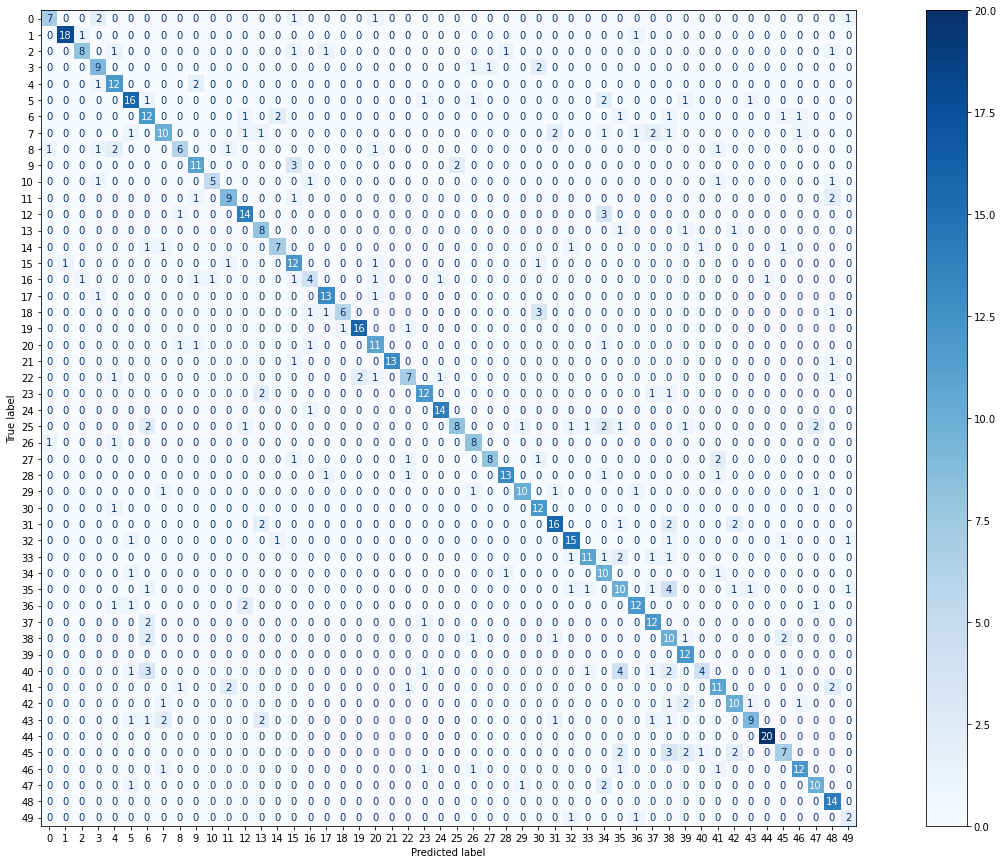

In [14]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

#Loading the best model
model = load_model('BestModel.hdf5')
#prediction
predictions = np.argmax(model.predict(testg), axis=-1)
#Visualization
c_matrix = confusion_matrix(label_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
plt.rcParams['figure.figsize'] = [25, 15]
disp.plot(cmap=plt.cm.Blues)
plt.show()
acc = accuracy_score(label_test, predictions)

We need to decode the IDs to names.

In [15]:
# Output decoding
def label_to_name(label):
    return df.iloc[label]['name']

Printing a few results:

In [16]:
# Show a few results
for i in range(10):
    print("The actual person: " , label_to_name(label_test[i]))
    print("The predicted person: " , label_to_name(predictions[i]))

The actual person:  Ana_Gasteyer
The predicted person:  Ana_Gasteyer
The actual person:  Alexandra_Daddario
The predicted person:  Alexandra_Daddario
The actual person:  Alexa_Davalos
The predicted person:  Alexa_Davalos
The actual person:  Abigail_Breslin
The predicted person:  Amy_Schumer
The actual person:  Abbie_Cornish
The predicted person:  Abbie_Cornish
The actual person:  Alice_Eve
The predicted person:  Alison_Pill
The actual person:  Alexandra_Roach
The predicted person:  Alexandra_Roach
The actual person:  Amaury_Nolasco
The predicted person:  Amaury_Nolasco
The actual person:  Alex_Borstein
The predicted person:  Alfre_Woodard
The actual person:  Amber_Riley
The predicted person:  Amber_Riley


Printing the test accuracy:

In [17]:
print("Accuracy: {:.2f}%".format((acc*100)))

Accuracy: 68.13%


A great way to evaluate a classification model is the EER (Equal Error Rate):

In [20]:
import statistics
from sklearn.metrics import roc_curve, auc

pred = model.predict(testg)
EER = []
for i in range(num_of_classes): 
    fpr, tpr, threshold = roc_curve(label_test, pred[:,i], pos_label=i)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
    EER.append(fpr[np.nanargmin(np.absolute((fnr - fpr)))])
# Calculate EER
print("EER: {:.2f}%".format((statistics.median(EER) * 100)))

EER: 6.22%


As a visualization, let's draw the ROC curve!

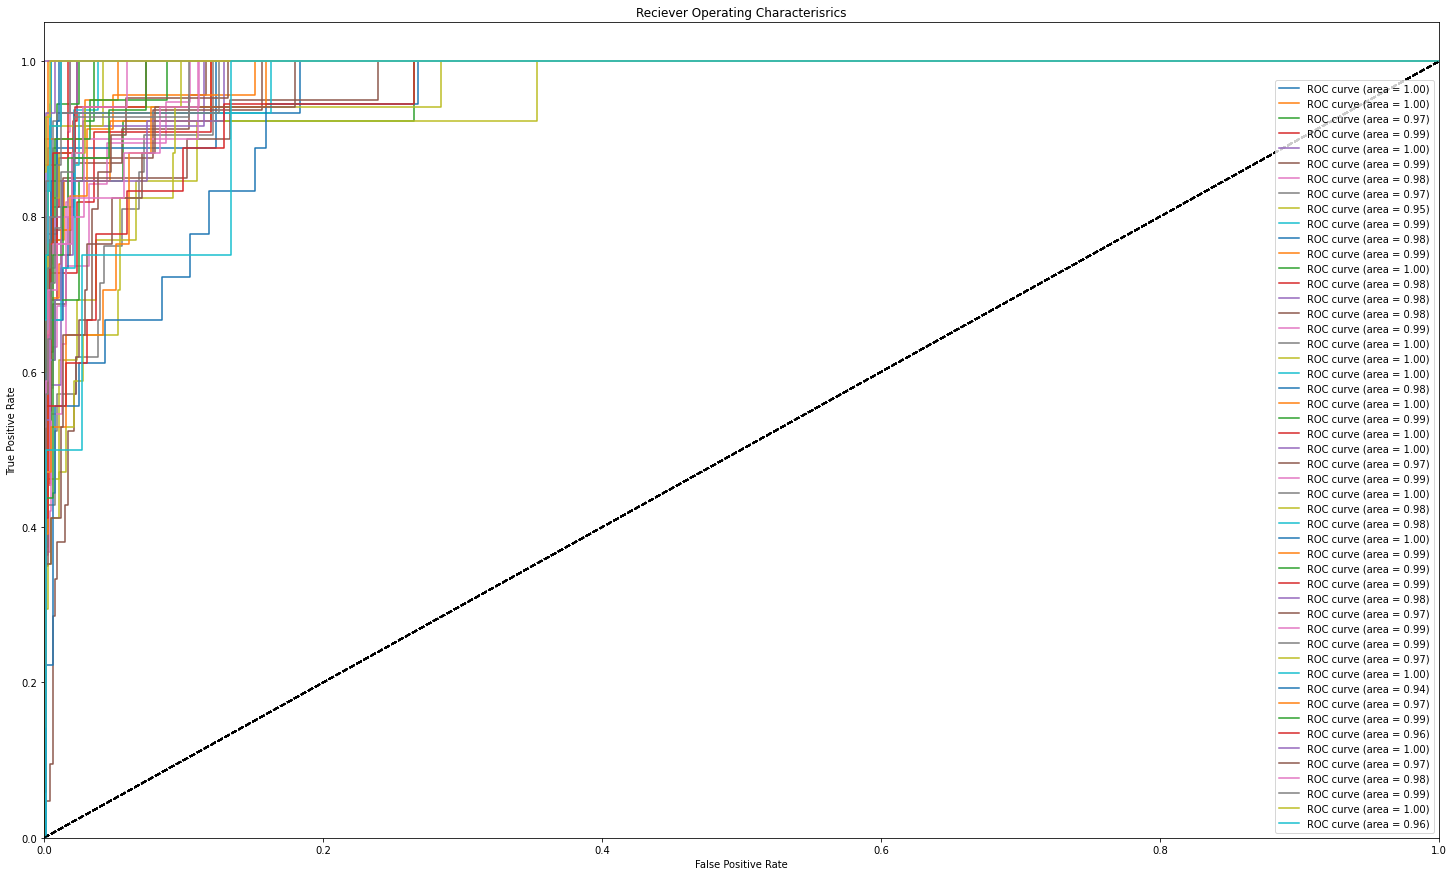

In [29]:
from sklearn.metrics import auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_of_classes):
    fpr[i], tpr[i], threshold  = roc_curve(label_test, pred[:, i], pos_label = i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(num_of_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characterisrics')
plt.legend(loc="lower right")
plt.show()

As the result of the optimizations, we have got the following model:

In [74]:
#The parameters of the final model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 129, 142, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 129, 142, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 140, 128)     73856     
_________________________________________________________________
activation_1 (Activation)    (None, 127, 140, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 70, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 70, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 70, 128)       1

### Building new models with different input parameters

For a better understanding, we wanted to test our model with different input parameters.

The first test was to check the result with higher number of classes:

#### num_of_classes = 200

We have to run the following code again.

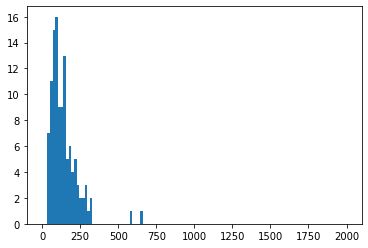

In [24]:
import matplotlib.pyplot as plt

# Storing th dataset (can be imbalanced)
wav_paths = []
classes = []
counts=[]

# To store the balanced dataset
new_class=[]
new_wav_path=[]

# Number of person we want to work with (up to ~1200)
num_of_classes=200

# Storing the paths for every audio files
for i in range(num_of_classes):
    temp=iterate(df.iloc[i]['relative_path'],wav_paths, classes, i)
    counts.append(temp)
    
# List to array
classes = np.array(classes)

# Making hystogram for visualizing the dataset
ls=[]
for i in counts:
    if i not in ls:
        ls.append(i)
plt.hist(ls, bins=len(ls), range=(0, 2000))
plt.title("The histogram of the dataset")
plt.xlabel("Quantity of data")
plt.ylabel("Number of people")
plt.show()

# Balancing the dataset
temp=-1
counter=10000

for i in range(len(wav_paths)):
    if temp!=classes[i]:
        if counter<(int)(np.average(counts)+30):
            start=i-counter
            end = i-1
            j=0
            while counter < (int)(np.average(counts)+30):
                new_wav_path.append(wav_paths[start+j])
                new_class.append(classes[start+j])
                j+=1
                if start+j+1 >end:
                    j=0
                counter += 1
        temp=classes[i]
        counter=0
    if counter<(int)(np.average(counts)+30):
        new_wav_path.append(wav_paths[i])
        new_class.append(classes[i])
        counter+=1
counter=0
temp=-1

Separation of the new dataset

In [25]:
from sklearn.model_selection import train_test_split

# Separation of train, test and validation data
wav_train, wav_test, label_train, label_test = train_test_split(new_wav_path, new_class, test_size=0.1)
wav_train, wav_val, label_train, label_val = train_test_split(wav_train, label_train, test_size=0.22)

Setting the input dimensions of the new dataset (it remained the same for now).

In [26]:
from scipy import signal

# The length of an audio data
dt = 2
# We process one audio file to get the input dimensions
aud = audio_open(wav_train[0])
aud, sr = pad_trunc(aud, 8, dt*1000)
# Generating spectogram
freq, time, spec = signal.spectrogram(aud[0], sr)
spec = np.reshape(spec, (spec.shape[0], spec.shape[1], 1))
# Getting the input dimension for the model
dim = spec.shape

#### The model is based on the best model of the optimizers

In [27]:
def model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=dim))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Creating the generators:

In [85]:
#Standardization and generator init
scaler = preprocessing.StandardScaler()

tg = TrainDataGenerator(wav_train, label_train, sr, dt,
                       num_of_classes,augmentation_size=8, scaler=scaler, batch_size=32)
vg = ValDataGenerator(wav_val, label_val, sr, dt,
                       num_of_classes, scaler=scaler, batch_size=32)
testg = ValDataGenerator(wav_test, label_test, sr, dt,
                       num_of_classes, scaler=scaler, batch_size=1)

Training with early stopping.

In [28]:
tuned_model = model()

#Adding callback functions
callback = EarlyStopping(monitor='val_loss', patience=15)
checkpoint = ModelCheckpoint(monitor='val_loss', filepath='BestModel.hdf5', save_best_only=True, verbose=1)
#Model training
tuned_model.fit(tg, validation_data=vg,callbacks=[checkpoint, callback],
              epochs=300, verbose=1)

Epoch 1/300
5229/5229 [==============================] - 1053s 201ms/step - loss: 5.3020 - accuracy: 0.0041 - val_loss: 5.3019 - val_accuracy: 0.0049

Epoch 00001: val_loss improved from inf to 5.30187, saving model to BestModel.hdf5
Epoch 2/300
5229/5229 [==============================] - 1044s 200ms/step - loss: 5.3003 - accuracy: 0.0044 - val_loss: 5.3039 - val_accuracy: 0.0032

Epoch 00002: val_loss did not improve from 5.30187
Epoch 3/300
5229/5229 [==============================] - 1044s 200ms/step - loss: 5.3002 - accuracy: 0.0045 - val_loss: 5.3051 - val_accuracy: 0.0032

Epoch 00003: val_loss did not improve from 5.30187
Epoch 4/300
5229/5229 [==============================] - 1060s 203ms/step - loss: 5.3001 - accuracy: 0.0044 - val_loss: 5.3055 - val_accuracy: 0.0041

Epoch 00004: val_loss did not improve from 5.30187
Epoch 5/300
5229/5229 [==============================] - 1043s 199ms/step - loss: 5.3001 - accuracy: 0.0046 - val_loss: 5.3057 - val_accuracy: 0.0027

Epoch 000

#### We can see a very low val_accuracy

#### Training with low audio length (1s)

We have to run some code again...

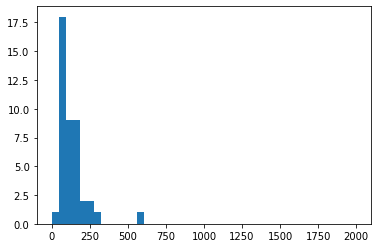

In [32]:
import matplotlib.pyplot as plt

# Storing th dataset (can be imbalanced)
wav_paths = []
classes = []
counts=[]

# To store the balanced dataset
new_class=[]
new_wav_path=[]

# Number of person we want to work with (up to ~1200)
num_of_classes=50

# Storing the paths for every audio files
for i in range(num_of_classes):
    temp=iterate(df.iloc[i]['relative_path'],wav_paths, classes, i)
    counts.append(temp)
    
# List to array
classes = np.array(classes)

# Making hystogram for visualizing the dataset
ls=[]
for i in counts:
    if i not in ls:
        ls.append(i)
plt.hist(ls, bins=len(ls), range=(0, 2000))
plt.title("The histogram of the dataset")
plt.xlabel("Quantity of data")
plt.ylabel("Number of people")
plt.show()

# Balancing the dataset
temp=-1
counter=10000

for i in range(len(wav_paths)):
    if temp!=classes[i]:
        if counter<(int)(np.average(counts)+30):
            start=i-counter
            end = i-1
            j=0
            while counter < (int)(np.average(counts)+30):
                new_wav_path.append(wav_paths[start+j])
                new_class.append(classes[start+j])
                j+=1
                if start+j+1 >end:
                    j=0
                counter += 1
        temp=classes[i]
        counter=0
    if counter<(int)(np.average(counts)+30):
        new_wav_path.append(wav_paths[i])
        new_class.append(classes[i])
        counter+=1
counter=0
temp=-1

In [33]:
from sklearn.model_selection import train_test_split

# Separation of train, test and validation data
wav_train, wav_test, label_train, label_test = train_test_split(new_wav_path, new_class, test_size=0.1)
wav_train, wav_val, label_train, label_val = train_test_split(wav_train, label_train, test_size=0.22)

Here, we change the length to 1s.

In [34]:
from scipy import signal

# The length of an audio data
dt = 1
# We process one audio file to get the input dimensions
aud = audio_open(wav_train[0])
aud, sr = pad_trunc(aud, 8, dt*1000)
# Generating spectogram
freq, time, spec = signal.spectrogram(aud[0], sr)
spec = np.reshape(spec, (spec.shape[0], spec.shape[1], 1))
# Getting the input dimension for the model
dim = spec.shape

The same model:

In [35]:
def model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=dim))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [37]:
#Standardization and generator init
scaler = preprocessing.StandardScaler()

tg = TrainDataGenerator(wav_train, label_train, sr, dt,
                       num_of_classes,augmentation_size=8, scaler=scaler, batch_size=32)
vg = ValDataGenerator(wav_val, label_val, sr, dt,
                       num_of_classes, scaler=scaler, batch_size=32)
testg = ValDataGenerator(wav_test, label_test, sr, dt,
                       num_of_classes, scaler=scaler, batch_size=1)

The training:

In [38]:
tuned_model = model()

#Adding callback functions
callback = EarlyStopping(monitor='val_loss', patience=15)
checkpoint = ModelCheckpoint(monitor='val_loss', filepath='BestModel.hdf5', save_best_only=True, verbose=1)
#Model training
tuned_model.fit(tg, validation_data=vg,callbacks=[checkpoint, callback],
              epochs=300, verbose=1)

Epoch 1/300
1353/1353 [==============================] - 123s 89ms/step - loss: 3.9141 - accuracy: 0.0184 - val_loss: 3.9117 - val_accuracy: 0.0120

Epoch 00001: val_loss improved from inf to 3.91166, saving model to BestModel.hdf5
Epoch 2/300
1353/1353 [==============================] - 120s 89ms/step - loss: 3.9110 - accuracy: 0.0188 - val_loss: 3.9119 - val_accuracy: 0.0126

Epoch 00002: val_loss did not improve from 3.91166
Epoch 3/300
1353/1353 [==============================] - 120s 89ms/step - loss: 3.9123 - accuracy: 0.0221 - val_loss: 3.9118 - val_accuracy: 0.0126

Epoch 00003: val_loss did not improve from 3.91166
Epoch 4/300
1353/1353 [==============================] - 120s 89ms/step - loss: 3.9097 - accuracy: 0.0206 - val_loss: 3.9121 - val_accuracy: 0.0126

Epoch 00004: val_loss did not improve from 3.91166
Epoch 5/300
1353/1353 [==============================] - 120s 89ms/step - loss: 3.9093 - accuracy: 0.0228 - val_loss: 3.9125 - val_accuracy: 0.0126

Epoch 00005: val_lo

#### Here, the val_accuracy was also very low